In [77]:
import json
import ast
import pandas as pd
import csv
import requests
import time
import traceback
from sqlalchemy import *
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import datetime
import instaconfig
from pytz import timezone

from sklearn.neighbors.kde import KernelDensity
from sklearn.grid_search import GridSearchCV

instagram, database, search_tags = instaconfig.config()

engine = create_engine('mysql://%(user)s:%(pass)s@%(host)s' % database)
engine.execute('use instagram')

q = '''
    SELECT *
    FROM posts
    WHERE searched_tag IN 
    %s ;
    ''' % ("('" + "','".join(search_tags[:6]) + "')")  # :7

print q

df = pd.read_sql_query(q,con = engine)

%matplotlib inline
%pylab inline


    SELECT *
    FROM posts
    WHERE searched_tag IN 
    ('busk','busker','buskers','busking','streetmusic','streetmusician') ;
    
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [78]:
filter_coord = {
    'ul_lat' : 37.85,
    'ul_long' : -122.35,
    'lr_lat' : 37.7,
    'lr_long' : -122.6
    }

sf_df = df[(df.lat <= filter_coord['ul_lat']) & (df.longitude <= filter_coord['ul_long']) & (df.lat >= filter_coord['lr_lat']) & (df.longitude >= filter_coord['lr_long'])]

sf_df = sf_df.reset_index()

sf_df.count()

index            507
searched_tag     507
created_time     507
post_id          507
image_url          0
lat              507
likes            507
longitude        507
post_url         507
text             507
user_id          507
date_time        507
date_year        507
date_month       507
date_week          0
date_day         507
day_of_week      507
media_type       507
low_res_url      507
thumbnail_url    507
stand_res_url    507
live_music         0
genre              0
dtype: int64

In [79]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

Xtrain = np.vstack((sf_df.longitude, sf_df.lat)).T
Xtrain *= np.pi/180

##############################################################################
# Compute DBSCAN
db = DBSCAN(eps=2e-5, min_samples=4).fit(Xtrain)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

sf_df['cluster_label'] = pd.Series(labels)

Estimated number of clusters: 23


In [80]:
import folium
from IPython.display import IFrame

from geopy.geocoders import Nominatim

#search_location = 'San Francisco'

#geolocator = Nominatim()

#geolocation = geolocator.geocode(search_location)

map_osm = folium.Map(location=[filter_coord['ul_lat'], filter_coord['ul_long']],
                    tiles='OpenStreetMap')

pics = sf_df[['lat','longitude','stand_res_url']].values

colors = [
    '#d73027',
    '#f46d43',
    '#fdae61',
    '#fee090',
    '#e0f3f8',
    '#abd9e9',
    '#74add1',
    '#4575b4'
]

color_labels = [colors[label % 7] for label in labels]
#color_labels = 1;

def make_circle(lat,lon,image_url,color_label): 
    map_osm.circle_marker(
        location = [lat,lon],
        radius=100,
        line_color=color_label,
        fill_color=color_label,
        popup = '<img src={url} width=200 height=200><br>'.format(
            url=image_url)
    )
    
make_circle_vec = np.vectorize(make_circle)

make_circle_vec(pics[:,0],pics[:,1],pics[:,2],color_labels)

map_osm.create_map(path='osm.html')

IFrame('osm.html', 700, 700)

In [223]:
df1 = sf_df[['created_time','cluster_label']]
df1['day_of_week'] = sf_df['created_time'].apply(lambda x: int(datetime.datetime.fromtimestamp(x).weekday()))
df1['day_of_month'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).day)
df1['hour_of_day'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
df1['month'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).month)
df1['year'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).year)

aaa = df1.groupby(['year','month','day_of_month','hour_of_day','day_of_week']).count()
#(df1.groupby(['day_of_week','hour_of_day'])['created_time'].count()/249).plot()


#aaa.groupby(['year']).count()

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

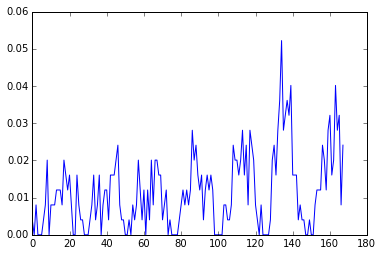

In [226]:
occupancy = (aaa.reset_index().groupby(['day_of_week','hour_of_day']).count()['year']/249).reset_index()

day_bins = np.zeros([7,24])

#for ii in xrange(0,7):
#    day_bins[ii] = np.zeros(24)

for ii in occupancy.index:
     day_bins[int(occupancy.loc[ii]['day_of_week'])][int(occupancy.loc[ii]['hour_of_day'])] = occupancy.loc[ii]['year']

plot(day_bins.reshape([7*24]))

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


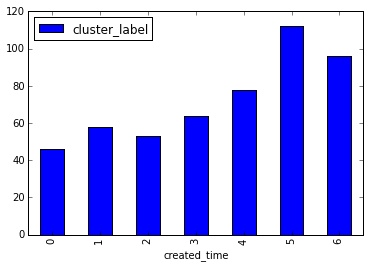

In [93]:
# Pictures binned by day of the week

df1 = sf_df[['created_time','cluster_label']]
df1['created_time'] = sf_df['created_time'].apply(lambda x: int(datetime.datetime.fromtimestamp(x).weekday()))
df1.groupby(['created_time']).count().plot(kind = 'bar')

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


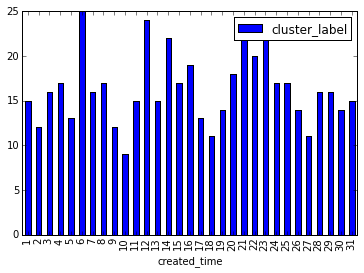

In [84]:
# Pictures binned by day of month
df1['created_time'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).day)
df1.groupby(['created_time']).count().plot(kind = 'bar')

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


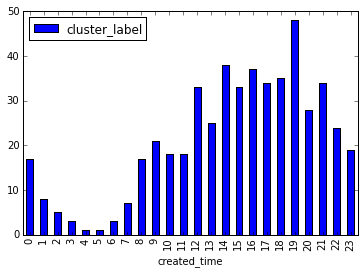

In [86]:
# Pictures binned by hour of day
df1['created_time'] = sf_df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
df1.groupby(['created_time']).count().plot(kind = 'bar')

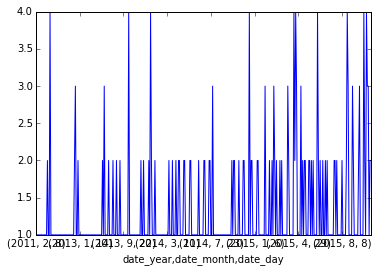

In [90]:
df1 = sf_df.groupby(['date_year','date_month','date_day']).count()['post_id'].plot()

/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [121]:
dt = datetime.datetime.now() - datetime.datetime.fromtimestamp(1291952805)

dt.days / 7

249